In [310]:
import pandas as pd
import numpy as np

In [311]:
df = pd.read_csv('datos/aguas_subterraneas_2020.csv')
df.head()

,CLAVE,SITIO,ORGANISMO_DE_CUENCA,ESTADO,MUNICIPIO,ACUIFERO,SUBTIPO,LONGITUD,LATITUD,PERIODO,...,CUMPLE_CON_DUR,CUMPLE_CON_CF,CUMPLE_CON_NO3,CUMPLE_CON_AS,CUMPLE_CON_CD,CUMPLE_CON_CR,CUMPLE_CON_HG,CUMPLE_CON_PB,CUMPLE_CON_MN,CUMPLE_CON_FE
0,DLAGU6,POZO SAN GIL,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,ASIENTOS,VALLE DE CHICALOTE,POZO,-102.02210,22.20887,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
1,DLAGU6516,POZO R013 CA�ADA HONDA,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,AGUASCALIENTES,VALLE DE CHICALOTE,POZO,-102.20075,21.99958,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
2,DLAGU7,POZO COSIO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,COSIO,VALLE DE AGUASCALIENTES,POZO,-102.28801,22.36685,2020,...,SI,SI,SI,NO,SI,SI,SI,SI,SI,SI
3,DLAGU9,POZO EL SALITRILLO,LERMA SANTIAGO PACIFICO,AGUASCALIENTES,RINCON DE ROMOS,VALLE DE AGUASCALIENTES,POZO,-102.29449,22.18435,2020,...,SI,SI,SI,SI,SI,SI,SI,SI,SI,SI
4,DLBAJ107,RANCHO EL TECOLOTE,PENINSULA DE BAJA CALIFORNIA,BAJA CALIFORNIA SUR,LA PAZ,TODOS SANTOS,POZO,-110.24480,23.45138,2020,...,SI,SI,NO,SI,SI,SI,SI,SI,SI,SI


In [312]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 57 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   CLAVE                 1068 non-null   object 
 1   SITIO                 1068 non-null   object 
 2   ORGANISMO_DE_CUENCA   1068 non-null   object 
 3   ESTADO                1068 non-null   object 
 4   MUNICIPIO             1068 non-null   object 
 5   ACUIFERO              1068 non-null   object 
 6   SUBTIPO               1068 non-null   object 
 7   LONGITUD              1068 non-null   float64
 8   LATITUD               1068 non-null   float64
 9   PERIODO               1068 non-null   int64  
 10  ALC_mg/L              1064 non-null   float64
 11  CALIDAD_ALC           1064 non-null   object 
 12  CONDUCT_mS/cm         1062 non-null   float64
 13  CALIDAD_CONDUC        1062 non-null   object 
 14  SDT_mg/L              0 non-null      float64
 15  SDT_M_mg/L           

Del resultado anterior se observa columnas que contienen la misma información pero en tipo de datos diferntes. También hay columnas numéricas detectadas como tipo "object". Vamos a extraer primero todas las columnas categóricas y binarias, ya que son candidatas a ser eliminadas.

In [313]:
#Obtenemos las columnas binarias o categóricas ya que tienen información repetida. Estas son candidatas a eliminarse
cols_to_drop  = df.columns[df.columns.str.contains('CALIDAD|CUMPLE')].to_list()
cols_to_drop


['CALIDAD_ALC',
 'CALIDAD_CONDUC',
 'CALIDAD_SDT_ra',
 'CALIDAD_SDT_salin',
 'CALIDAD_FLUO',
 'CALIDAD_DUR',
 'CALIDAD_COLI_FEC',
 'CALIDAD_N_NO3',
 'CALIDAD_AS',
 'CALIDAD_CD',
 'CALIDAD_CR',
 'CALIDAD_HG',
 'CALIDAD_PB',
 'CALIDAD_MN',
 'CALIDAD_FE',
 'CUMPLE_CON_ALC',
 'CUMPLE_CON_COND',
 'CUMPLE_CON_SDT_ra',
 'CUMPLE_CON_SDT_salin',
 'CUMPLE_CON_FLUO',
 'CUMPLE_CON_DUR',
 'CUMPLE_CON_CF',
 'CUMPLE_CON_NO3',
 'CUMPLE_CON_AS',
 'CUMPLE_CON_CD',
 'CUMPLE_CON_CR',
 'CUMPLE_CON_HG',
 'CUMPLE_CON_PB',
 'CUMPLE_CON_MN',
 'CUMPLE_CON_FE']

Ahora revisemos una de las columnas numéricas que fue detectada como object.

In [314]:
df['CD_TOT_mg/L'].value_counts()

<0.003     1066
0.0056        1
0.03211       1
Name: CD_TOT_mg/L, dtype: int64

De lo anterior se observa que valores muy pequeños son colocados como "<". Para ello, vamos a reemplazar este string por un valor arbitrario por debajo del umbral, de manera que podamos crear una cota inferior y así analizarlo por medio de un histograma o boxplot.

In [315]:
#Definimos las variables numéricas a analizar
vars = ['ALC_mg/L','AS_TOT_mg/L', 'CD_TOT_mg/L', 'FE_TOT_mg/L', 'SDT_M_mg/L','SDT_mg/L', 'FLUORUROS_mg/L' ]
vars2 = ['COLI_FEC_NMP/100_mL', 'CONDUCT_mS/cm', 'CR_TOT_mg/L', 'DUR_mg/L', 'HG_TOT_mg/L', 'MN_TOT_mg/L', 'N_NO3_mg/L', 'PB_TOT_mg/L']

limits = {}
for  var in vars:
        if  (df[var].dtypes == 'object'):
                #Obtenemos las observaciones que solo tengan < > o =
                limits[var] = df[df[var].str.contains('<|>|=', na='na') == True][var].value_counts().index
#Lo convertimos en DF para mejor visualización
limits_df = pd.DataFrame(limits)
display(limits_df.style.hide(axis = 'index'))

AS_TOT_mg/L,CD_TOT_mg/L,FE_TOT_mg/L,SDT_M_mg/L,FLUORUROS_mg/L
<0.01,<0.003,<0.025,<25,<0.2


Se observan que 5 variables tienen valores string. Vamos a proceder sustituir estos strings por valores numéricos.

In [316]:
#Buscamos valores por debajo del umbral que se observa en los datos
limits = {
   'FE_TOT_mg/L': 0.024,
   'FLUORUROS_mg/L': 0.1,
   'SDT_M_mg/L': 24,
   'CD_TOT_mg/L' : 0.002,
   'AS_TOT_mg/L': 0.005
}

#Hacemos la sustitución
for col in limits_df.columns:
   str_to_match = limits_df[[col]].iloc[0].values[0]

   df.loc[df[col] == str_to_match, col] = limits[col]

In [317]:
#Convertimos a un tipo float
df[limits_df.columns] = df[limits_df.columns].astype(float)

In [318]:
#Probamos la conversión con una de las columnas
df[['FE_TOT_mg/L']].sort_values(by = 'FE_TOT_mg/L', ascending = False)

,FE_TOT_mg/L
425,178.6150
331,16.4371
9,14.0600
799,13.4400
561,7.3820
...,...
675,0.0240
672,0.0240
671,0.0240
670,0.0240


<AxesSubplot: >

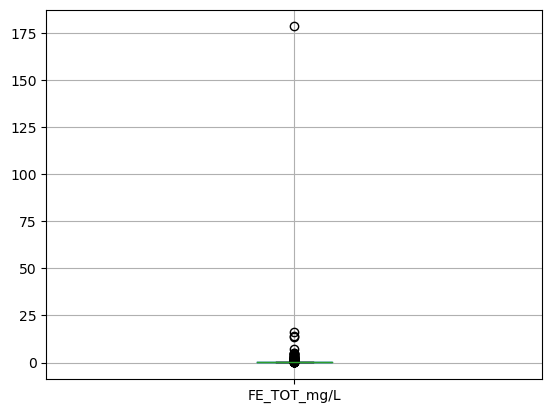

In [319]:
df[['FE_TOT_mg/L']].boxplot()

array([[<AxesSubplot: title={'center': 'FE_TOT_mg/L'}>]], dtype=object)

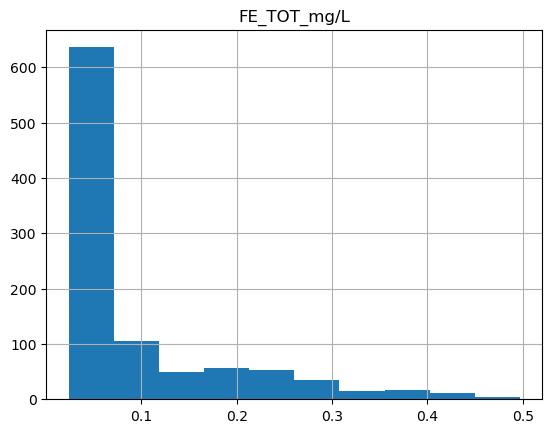

In [320]:
df_test = df.drop(index = df[df['FE_TOT_mg/L'] > 0.5].index)
df_test[['FE_TOT_mg/L']].hist()

In [321]:
df[['SDT_mg/L']].value_counts()

Series([], dtype: int64)

In [322]:
df[['SDT_M_mg/L']].value_counts()

SDT_M_mg/L
292.0         4
320.0         4
380.0         4
496.0         4
317.0         4
             ..
444.0         1
445.4         1
446.0         1
449.0         1
82170.0       1
Length: 925, dtype: int64

In [323]:
df[['ALC_mg/L']].value_counts()

ALC_mg/L
157.62      5
257.85      4
168.72      4
197.58      4
161.00      4
           ..
189.72      1
189.81      1
190.05      1
190.06      1
1650.00     1
Length: 816, dtype: int64

<AxesSubplot: >

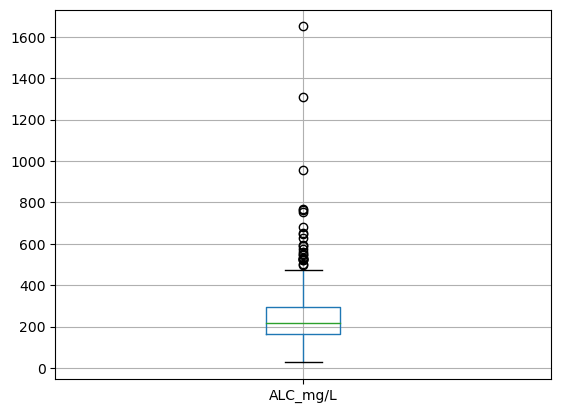

In [324]:
df[['ALC_mg/L']].boxplot()

In [325]:
df[['FLUORUROS_mg/L']].value_counts()

FLUORUROS_mg/L
0.1000            162
0.4660              3
0.5202              3
0.5900              2
0.5620              2
                 ... 
0.4523              1
0.4542              1
0.4570              1
0.4592              1
34.8033             1
Length: 862, dtype: int64

In [326]:
df['CUMPLE_CON_FE'].value_counts()

SI    932
NO    136
Name: CUMPLE_CON_FE, dtype: int64

In [327]:
y = df[['SEMAFORO']]
y.head()

,SEMAFORO
0,Verde
1,Verde
2,Rojo
3,Verde
4,Rojo


In [328]:
(y.value_counts()/len(y)) * 100

SEMAFORO
Verde       40.636704
Rojo        36.235955
Amarillo    23.127341
dtype: float64

In [329]:
columns_to_drop = df.columns[10:41].to_list()
columns_to_drop.append('CONTAMINANTES')
X = df.drop(columns_to_drop, axis = 1)

In [330]:
df.isna().any().sum()

13

In [331]:
df.isna().sum()

CLAVE                      0
SITIO                      0
ORGANISMO_DE_CUENCA        0
ESTADO                     0
MUNICIPIO                  0
ACUIFERO                   0
SUBTIPO                    0
LONGITUD                   0
LATITUD                    0
PERIODO                    0
ALC_mg/L                   4
CALIDAD_ALC                4
CONDUCT_mS/cm              6
CALIDAD_CONDUC             6
SDT_mg/L                1068
SDT_M_mg/L                 2
CALIDAD_SDT_ra             2
CALIDAD_SDT_salin          2
FLUORUROS_mg/L             0
CALIDAD_FLUO               0
DUR_mg/L                   1
CALIDAD_DUR                1
COLI_FEC_NMP/100_mL        0
CALIDAD_COLI_FEC           0
N_NO3_mg/L                 1
CALIDAD_N_NO3              1
AS_TOT_mg/L                0
CALIDAD_AS                 0
CD_TOT_mg/L                0
CALIDAD_CD                 0
CR_TOT_mg/L                0
CALIDAD_CR                 0
HG_TOT_mg/L                0
CALIDAD_HG                 0
PB_TOT_mg/L   

In [332]:
na_columns = df.columns[df.isna().any()].to_list()

In [333]:
df[na_columns].isna().sum()

ALC_mg/L                4
CALIDAD_ALC             4
CONDUCT_mS/cm           6
CALIDAD_CONDUC          6
SDT_mg/L             1068
SDT_M_mg/L              2
CALIDAD_SDT_ra          2
CALIDAD_SDT_salin       2
DUR_mg/L                1
CALIDAD_DUR             1
N_NO3_mg/L              1
CALIDAD_N_NO3           1
CONTAMINANTES         434
dtype: int64